In [1562]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

## Step 1 - Load the data

In [1564]:
df=pd.read_csv(r"E:\Credit Risk Analysis\loan.csv",low_memory=False,nrows=50000)

In [1565]:
df.shape

(50000, 145)

In [1566]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Step 2 - Data Cleaning

In [1568]:
#Select relevant numerical columns and categorical columns
numerical_cols=['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 
                  'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'last_pymnt_amnt', 
                  'mort_acc', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_op_rev_tl', 'num_rev_accts']

categorical_cols=['grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status']
target_col='loan_status'

columns_to_use=numerical_cols+categorical_cols+[target_col]
df=df[columns_to_use].dropna()
df.shape

(45414, 28)

In [1569]:
# converting loan_status to binary (0=Full paid , 1=default)
df['loan_status']=df['loan_status'].apply(lambda x:0 if x=='Fully Paid' else 1)

#Encoding Categorical Columns using LabelEncoder
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

#Removing outliers in 'annual_inc'
df=df[df['annual_inc']<df['annual_inc'].quantile(0.99)]
print("Shape after removing outliers : ",df.shape)

Shape After Outlier Removal :  (44886, 28)


## Step 3 - Exploratory Data Analysis (EDA)

In [1571]:
print("Loan Status Distribution : ",df['loan_status'].value_counts(normalize=True))

Loan Status Distribution :  loan_status
1    0.979281
0    0.020719
Name: proportion, dtype: float64


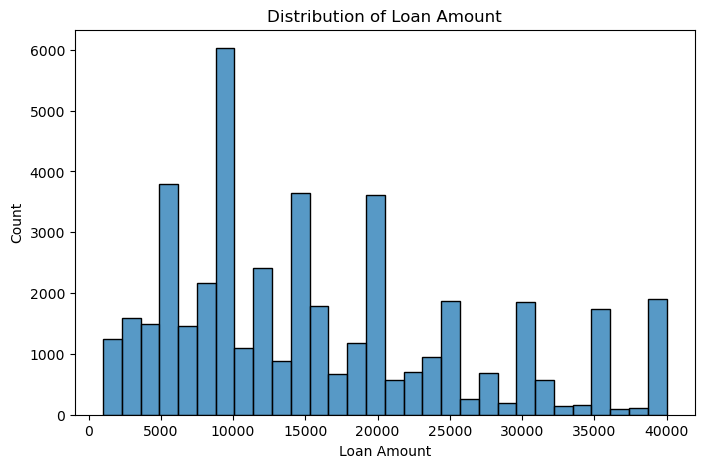

In [1572]:
# Visualization - 1
plt.figure(figsize=(8,5))
sns.histplot(df['loan_amnt'],bins=30)
plt.title('Distribution of Loan Amount')
plt.xlabel("Loan Amount")
plt.ylabel("Count")
plt.show()

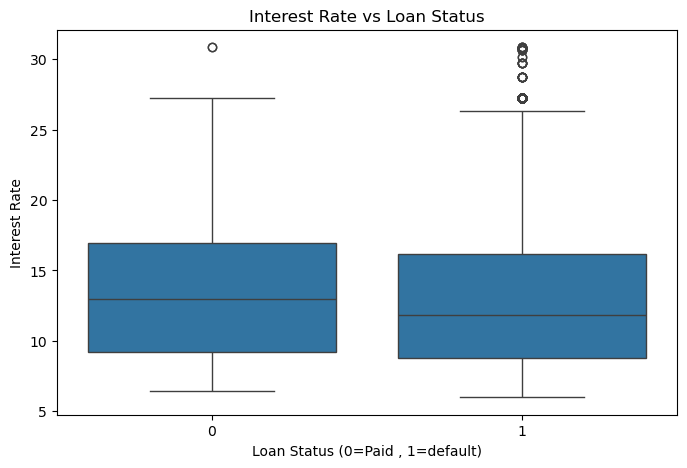

In [1573]:
# Visualization 2 - Interest Rate ve Loan Status
plt.figure(figsize=(8,5))
sns.boxplot(x="loan_status",y='int_rate',data=df)
plt.title("Interest Rate vs Loan Status")
plt.xlabel('Loan Status (0=Paid , 1=default)')
plt.ylabel('Interest Rate')
plt.show()

## Step 4 - Prepare Data for Modelling

In [1575]:
X=df.drop('loan_status',axis=1)
y=df['loan_status']

In [1576]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [1577]:
# Select the Features
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)


In [1578]:
# Handle class imbalance with SMOTE (3:1 for majority:minority)
smote=SMOTE(random_state=42, sampling_strategy=0.3)
X_train_scaled,y_train=smote.fit_resample(X_train_scaled,y_train)
print("After SMOTE, Training Data Shape : ",X_train_scaled.shape)
print("After SMOTE, y_Train Distrobution : ",pd.Series(y_train).value_counts(normalize=True))

After SMOTE, Training Data Shape :  (45737, 27)
After SMOTE, y_Train Distrobution :  loan_status
1    0.769246
0    0.230754
Name: proportion, dtype: float64


## Step 6 - Build and train Random Forest Model


In [1580]:
model=RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=5,
    class_weight='balanced'
)
model.fit(X_train_scaled,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

## Step 6 - Predictions and Evaluations

In [1582]:
y_pred=model.predict(X_test_scaled)

In [1583]:
# Accuracy
accuracy=accuracy_score(y_test,y_pred)
print("Random Forest Accuracy : ",accuracy)

Random Forest Accuracy :  0.9942080641568278


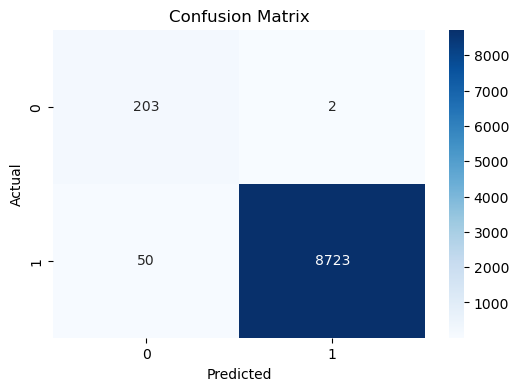

In [1584]:
# Confusion Matrix
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [1585]:
# Classification Report
print("Classification Report :\n",classification_report(y_test,y_pred))

Classification Report :
               precision    recall  f1-score   support

           0       0.80      0.99      0.89       205
           1       1.00      0.99      1.00      8773

    accuracy                           0.99      8978
   macro avg       0.90      0.99      0.94      8978
weighted avg       1.00      0.99      0.99      8978



## Step 7 - Feature Importance

In [1587]:
feature_importance=pd.DataFrame({
    'Feature' : X.columns,
    'Importance' : model.feature_importances_
})
print("Feature Importance :\n",feature_importance)

Feature Importance :
                 Feature  Importance
0             loan_amnt    0.020139
1              int_rate    0.002226
2           installment    0.011312
3            annual_inc    0.000397
4                   dti    0.002563
5           delinq_2yrs    0.001152
6        inq_last_6mths    0.014493
7              open_acc    0.000551
8               pub_rec    0.000065
9             revol_bal    0.000722
10           revol_util    0.002000
11            total_acc    0.000354
12          total_pymnt    0.362838
13      last_pymnt_amnt    0.468830
14             mort_acc    0.018591
15       num_actv_bc_tl    0.013449
16      num_actv_rev_tl    0.009326
17          num_bc_sats    0.001753
18            num_bc_tl    0.000731
19        num_op_rev_tl    0.000484
20        num_rev_accts    0.001270
21                grade    0.005215
22           emp_length    0.013975
23       home_ownership    0.010778
24  verification_status    0.006037
25              purpose    0.029984
26  in

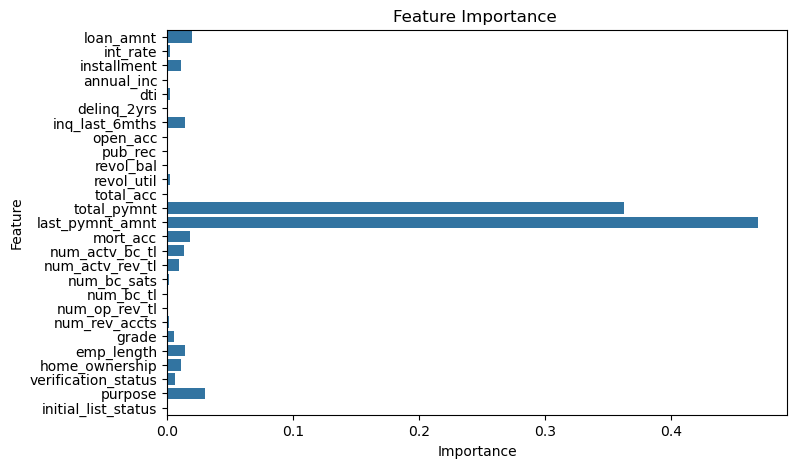

In [1588]:
## Visualization 3 - Feature Importance
plt.figure(figsize=(8,5))
sns.barplot(x='Importance',y='Feature',data=feature_importance)
plt.title("Feature Importance ")
plt.show()